In [20]:
import sys
sys.path.append('/home/rustam/EyePit/Danil_tests/MakiFlow/')
from makiflow.models import Segmentator
from makiflow.layers import *
import makiflow as mf
import tensorflow as tf
import cv2
mf.set_main_gpu(1)

First we need to provide a path provider to our data that will tell the generator where to load the data from.
For this purpose we're gonna create a generator that is gonna yield strings with path to the necessary data.

In [4]:
from makiflow.models.segmentation.gen_base import PathGenerator, SegmentIterator

The path provider must inherited from the <b>PathGenerator</b> class.

In [5]:
images_path = '/mnt/data/med_data/pipeline_data/images/'
masks_path = '/mnt/data/med_data/pipeline_data/masks/'

In [38]:
from glob import glob
import os
import numpy as np


class Generator(PathGenerator):
    def __init__(self, path_imgs, path_masks):
        self.images = glob(os.path.join(path_imgs, '*.bmp'))
        print(self.images[0])
        self.masks = glob(os.path.join(path_masks, '*.bmp'))
        
    def next_element(self):
        while True:
            index = 0
            
            yield {
                SegmentIterator.image: self.images[index],
                SegmentIterator.mask: self.masks[index]
            }

## Map method

The next step is to create a map method that will map from the path string to the actual data, i.e. it's a function that loads the data according the given paths.

In [39]:
# Example map method
def ex_map_method(data_paths):
    img_file = tf.read_file(data_paths[SegmentationGenerator.image])
    mask_file = tf.read_file(data_paths[SegmentationGenerator.mask])

    img = tf.image.decode_image(img_file)
    mask = tf.image.decode_image(mask_file)

    img.set_shape([1024, 1024, 3])
    mask.set_shape([1024, 1024, 3])
    
    # The mask has three channels so we need to squeeze it
    mask = mask[:, :, 0]
    
    img = tf.cast(img, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.int32)
    return img, mask

MakiFlow provides already built map methods.
<b><ol>
    <li>LoadResizeNormalize - shortcut method</li>
    <li>LoadDataMethod - constructive method (the beginning block)</li>
    <li>ResizePostMethod - constructive method</li>
    <li>NormalizePostMethod - constructive method</li>
    <li>SqueezeMaskPostMethod - constructive method</li>
    <li>ComputePositivesPostMethod - constructive method</li>
</ol></b>


Let's create a map method by combining the aforementioned ones.

In [40]:
from makiflow.models.segmentation.map_methods import LoadDataMethod, ResizePostMethod, ComputePositivesPostMethod, \
    SqueezeMaskPostMethod, NormalizePostMethod

In [41]:
map_method = LoadDataMethod(image_shape=[1024, 1024, 3], mask_shape=[1024, 1024, 1])

In [42]:
map_method = NormalizePostMethod()(map_method)

In [43]:
map_method = SqueezeMaskPostMethod()(map_method)

## Generator Layer

After acquiring map method and path provider we can create the generator layer. This layer will feed the network with the data.

In [44]:
from makiflow.models.segmentation.gen_layers import InputGenLayer

In [45]:
gen_layer = InputGenLayer(
    prefetch_size=5,
    batch_size=1, 
    path_generator=Generator(images_path, masks_path),
    name='1',
    map_operation=map_method
)

/mnt/data/med_data/pipeline_data/images/beta__31584.bmp


In [14]:
sess = tf.Session()

In [46]:
iterator = gen_layer.get_iterator()

In [47]:
mask = iterator[SegmentIterator.mask]

In [48]:
image = iterator[SegmentIterator.image]

In [49]:
image_, mask_ = sess.run([image, mask])

In [69]:
image_[0]

array([[[0.47058824, 0.21176471, 0.08627451],
        [0.46666667, 0.21176471, 0.08627451],
        [0.4627451 , 0.22352941, 0.08235294],
        ...,
        [0.6901961 , 0.36862746, 0.16078432],
        [0.69803923, 0.37254903, 0.16078432],
        [0.7019608 , 0.38039216, 0.15686275]],

       [[0.46666667, 0.21568628, 0.08627451],
        [0.4627451 , 0.22352941, 0.08235294],
        [0.45882353, 0.23137255, 0.08235294],
        ...,
        [0.70980394, 0.3882353 , 0.17254902],
        [0.70980394, 0.3882353 , 0.16862746],
        [0.7058824 , 0.3882353 , 0.16078432]],

       [[0.4627451 , 0.22352941, 0.09019608],
        [0.4627451 , 0.23137255, 0.09411765],
        [0.4627451 , 0.23921569, 0.09803922],
        ...,
        [0.7137255 , 0.39607844, 0.16078432],
        [0.7137255 , 0.39215687, 0.16078432],
        [0.7058824 , 0.38039216, 0.15686275]],

       ...,

       [[0.34117648, 0.18039216, 0.07058824],
        [0.3372549 , 0.1764706 , 0.07450981],
        [0.3372549 , 0

In [60]:
images = glob(os.path.join(images_path, '*.bmp'))

In [72]:
image_cv = cv2.imread(images[0])

In [70]:
image_cv = image_cv / 255

In [71]:
image_cv

array([[[0.08627451, 0.21176471, 0.47058824],
        [0.08627451, 0.21176471, 0.46666667],
        [0.08235294, 0.22352941, 0.4627451 ],
        ...,
        [0.16078431, 0.36862745, 0.69019608],
        [0.16078431, 0.37254902, 0.69803922],
        [0.15686275, 0.38039216, 0.70196078]],

       [[0.08627451, 0.21568627, 0.46666667],
        [0.08235294, 0.22352941, 0.4627451 ],
        [0.08235294, 0.23137255, 0.45882353],
        ...,
        [0.17254902, 0.38823529, 0.70980392],
        [0.16862745, 0.38823529, 0.70980392],
        [0.16078431, 0.38823529, 0.70588235]],

       [[0.09019608, 0.22352941, 0.4627451 ],
        [0.09411765, 0.23137255, 0.4627451 ],
        [0.09803922, 0.23921569, 0.4627451 ],
        ...,
        [0.16078431, 0.39607843, 0.71372549],
        [0.16078431, 0.39215686, 0.71372549],
        [0.15686275, 0.38039216, 0.70588235]],

       ...,

       [[0.07058824, 0.18039216, 0.34117647],
        [0.0745098 , 0.17647059, 0.3372549 ],
        [0.0745098 , 0

In [74]:
import matplotlib.pyplot as plt

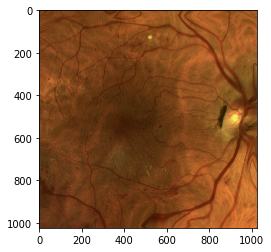

In [78]:
plt.imshow(image_[0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


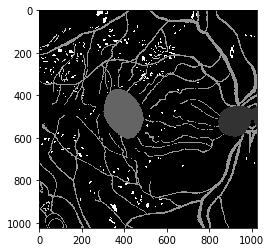

In [53]:
plt.imshow(np.concatenate([mask_[0]]*3, axis=2)*50)


## Build a model from generator

A model can be built using classic approach - layer by layer - or with the help of the builder.

In [13]:
from makiflow.save_recover import Builder

In [14]:
model = Builder.segmentator_from_json(
    json_path='model.json',
    generator=gen_layer
)



Model is restored!


## Training the model

The model can trained now using familiar, but a little bit different API.
At first we need to tell the model (Segmentator) that it's gonna be trained using generator.

In [15]:
model.set_generator(gen_layer)

In [16]:
model.set_session(tf.Session())

Then we set an optimizer and the number of epochs as usual. But in case of training using pipelines there's no common sense for epochs, so we need to define ourselves how long the epoch is.

In [17]:
optimizer = tf.train.AdamOptimizer()

In [18]:
epochs = 2
iterations = 10 # How many batches are processed during one epoch

In [19]:
model.genfit_focal(
    gamma=2.0,
    optimizer=optimizer,
    epochs=10,
    iterations=iterations
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 Focal loss: 5.0734


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 Focal loss: 1.1421


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2 Focal loss: 0.8308


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3 Focal loss: 0.7128


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4 Focal loss: 0.8267


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5 Focal loss: 0.6550


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6 Focal loss: 0.6466


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7 Focal loss: 0.7484


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8 Focal loss: 0.6001


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

Epoch: 9 Focal loss: 0.7665


{'train losses': [5.073395899922541,
  1.1421384554967398,
  0.8307723037700818,
  0.7128402018190465,
  0.8267178009763763,
  0.655004996051306,
  0.6465906465727793,
  0.7483962438812546,
  0.6001497576377489,
  0.7665426405644897]}